In [255]:
from backend.daps.data import Devices, Speakers
from backend.daps.loader import DAPSLoader
from backend.audio_to_spectrogram_converter import AudioToSpectrogramConverter
from backend.tsrc.loader import TSRCLoader
from backend.tsrc.data import Environments
from backend import audio_data

import PIL
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import librosa

from ipywidgets import widgets
from ipywidgets import interactive
from IPython.display import Audio
from tqdm import tqdm

import cv2
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
path_to_spectrograms_raw = "../data/v2/tsrc_sprectrograms_without_clean"
path_to_spectrograms_denoised = "../data/v2/tsrc_sprectrograms"
path_to_spectrograms_audio = "../data/v2/tsrc_train_test/"

import cv2
import os

path_to_spectrograms = "../data/tsrc_sprectrograms/"

%load_ext autoreload
%autoreload 2

sns.set_theme(rc={'figure.figsize':(20,6)})

sns.set_theme(context='notebook', style = "white", palette=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Reading data
    </div>

In [256]:
class SpectrogramData():
    def __init__(self, file_path : str, speaker_id : str, recording_no : int , train_validaton_test : str, class_id : int):
        self.file_path = file_path
        self.speaker_id = speaker_id
        self.recording_no = recording_no
        self.train_validaton_test = train_validaton_test
        self.class_id = class_id

class SpectrogramLoader():
        
    @staticmethod
    def load_data(path):
        objects_list = []
        
        for subdir, dirs, files in os.walk(path):
            if dirs is not None:
                for file in files:
                    file_path = os.path.join(subdir, file)
                    file_path = os.path.normpath(file_path)
                    #print(file_path)
                    #print(file_path.split('\\'))
                    class_id = file_path.split('\\')[-2]
                    train_validaton_test = file_path.split('\\')[-3]
                    speaker_id = file[:8]
                    recording_no = file.removesuffix(".png").split("_")[1]

                    data_object = SpectrogramData(file_path=file_path,
                                                  speaker_id=speaker_id,
                                                  recording_no=int(recording_no),
                                                  train_validaton_test=train_validaton_test,
                                                  class_id=int(class_id))
                    objects_list.append(data_object)
        
        return objects_list
    
def colorHistogram(file_path, black_threshold):
    img = cv2.imread(file_path)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #plt.figure()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(imgRGB)
    
    colors = ['r', 'g', 'b']
    #plt.figure()
    
    mask = np.logical_not(np.all(imgRGB < black_threshold, axis=2)).astype(np.uint8)
    for i, color in enumerate(colors):
        hist = cv2.calcHist([imgRGB], [i], mask, [256], [0,256])
        axes[1].plot(hist, color,)
        
    plt.xlabel("Pixel intensity")
    plt.ylabel("# of Pixels")
    plt.show()
        

In [258]:
spectrogram_data = SpectrogramLoader().load_data(path_to_spektrograms)

audio_data = TSRCLoader('../data/audio').get_audio([Environments.cat, Environments.dog, Environments.bed, Environments.bird, Environments.down, Environments.eight])

enviroment_counts = {}
tag_list = []
sample_len_list = []
sample_rate_list = []
speaker_id_list = []
repetition_no_list = []


for audio in audio_data:
    tag_list.append(audio.tag)
    sample_len_list.append(len(audio.samples))
    sample_rate_list.append(audio.sample_rate)
    speaker_id_list.append(audio.speaker_id)
    repetition_no_list.append(audio.repetition_no)
    
df = pd.DataFrame({"tag": tag_list, 
                   "sample_len": sample_len_list, 
                   "sample_rate": sample_rate_list, 
                   "speaker_id": speaker_id_list,
                   "repetition_no" : repetition_no_list})
df['audio_length'] = df['sample_len'] / df['sample_rate']

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Overall statistics
    </div>

In [290]:
classes_id = [spec.class_id for spec in spectrogram_data]
df_classes_id = pd.DataFrame({'class_id' : [0, 1], 'count' : [len(classes_id) - np.count_nonzero(classes_id), np.count_nonzero(classes_id)]})

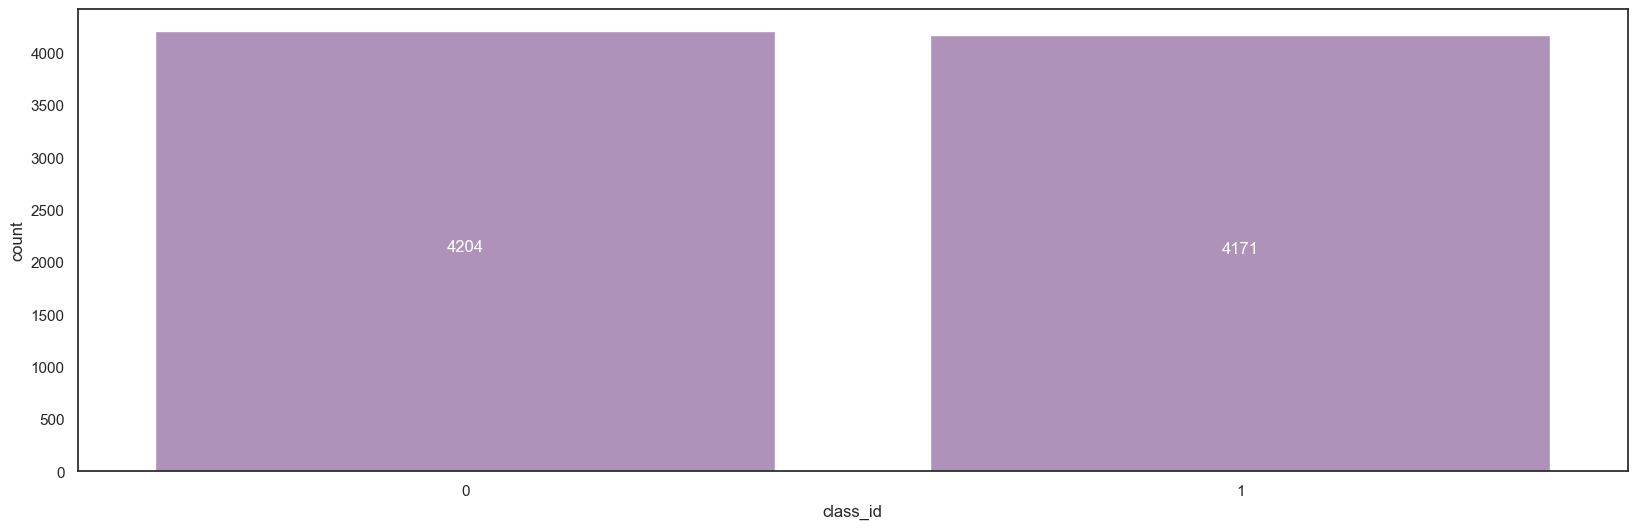

In [291]:
ax = sns.barplot(df_classes_id, x="class_id", y="count", color="#B28CBF")
for i, v in enumerate(df_classes_id['count']):
   ax.text(i, v/2, str(v), ha='center', color='white')

In [292]:
print(f"Audio files: {len(audio_data)}")
print(f"Number of unique speakers in train dataset: {len(df.speaker_id.unique())}")

Audio files: 11634
Number of unique speakers in train dataset: 1818


<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Audio statistics
    </div>

In [260]:
print(f"Mean audio length: {df.audio_length.mean()}s")
print(f"Variance of audio length: {df.audio_length.var()}s")

Mean audio length: 0.9831877283604978s
Variance of audio length: 0.003673075971218671s


C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='audio_length', ylabel='Count'>

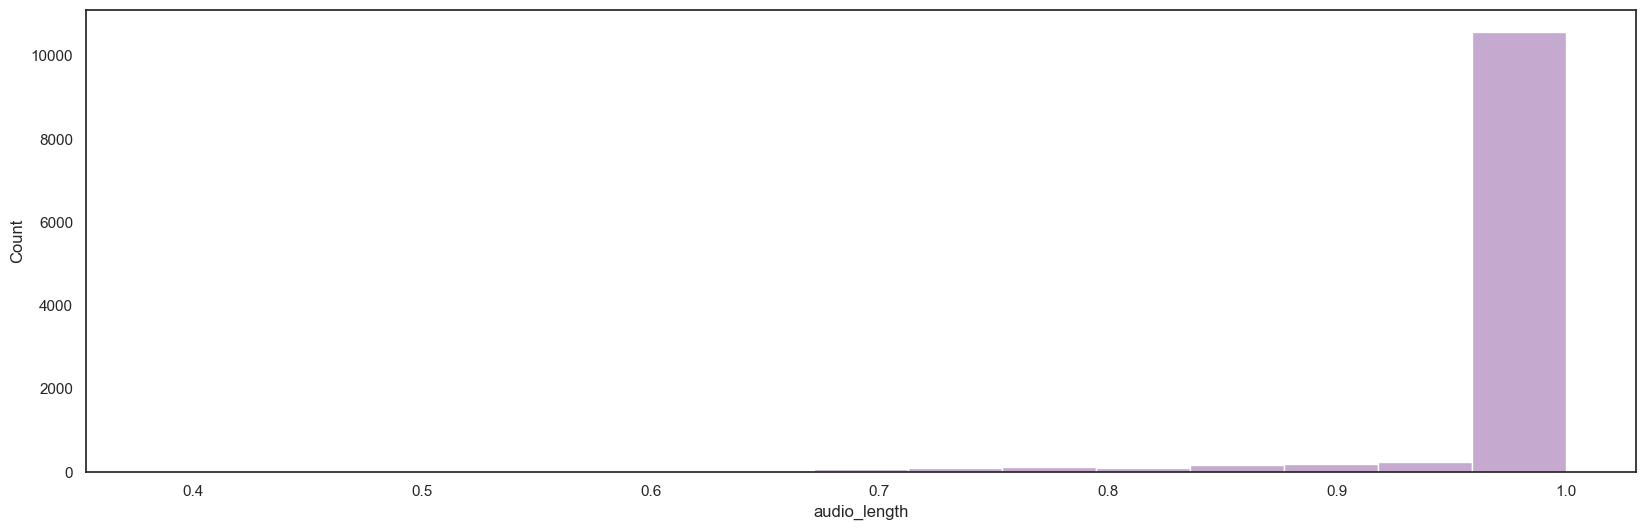

In [239]:
sns.histplot(df, x="audio_length", color="#B28CBF")

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Color histograms for same speaker
    </div>

In [195]:
unique_speakers = np.unique([spec.speaker_id for spec in spectrogram_data])

speaker_1 = [spec for spec in spectrogram_data if spec.speaker_id == unique_speakers[0]]

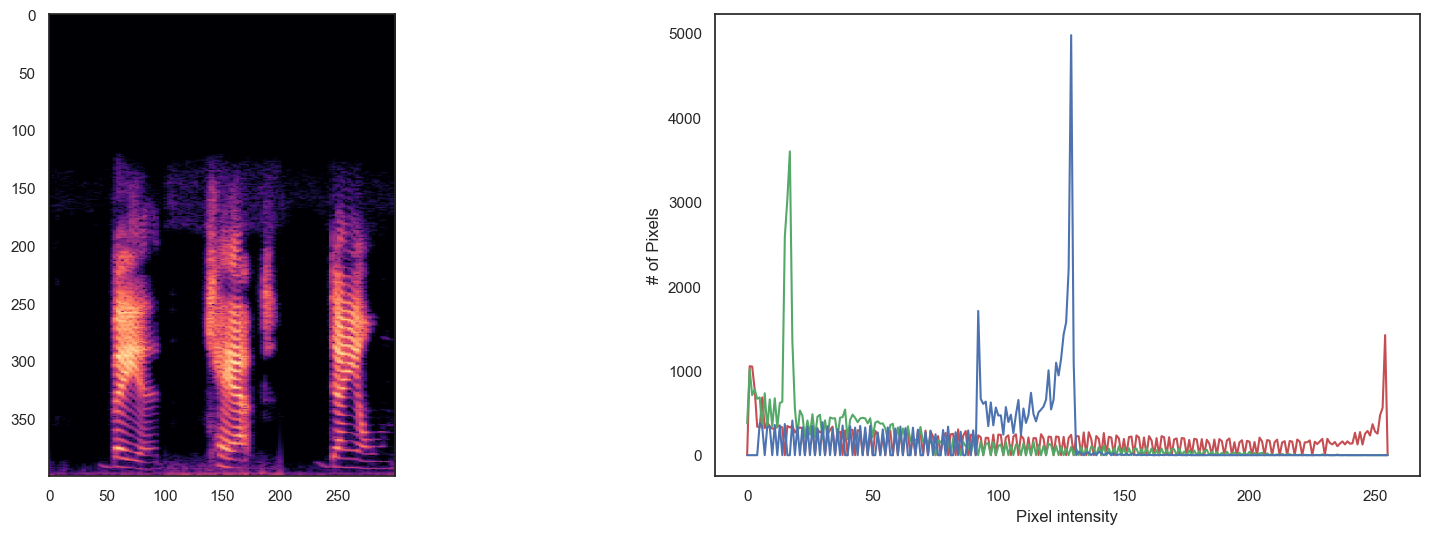

In [223]:
colorHistogram(speaker_1[0].file_path, black_threshold=5)

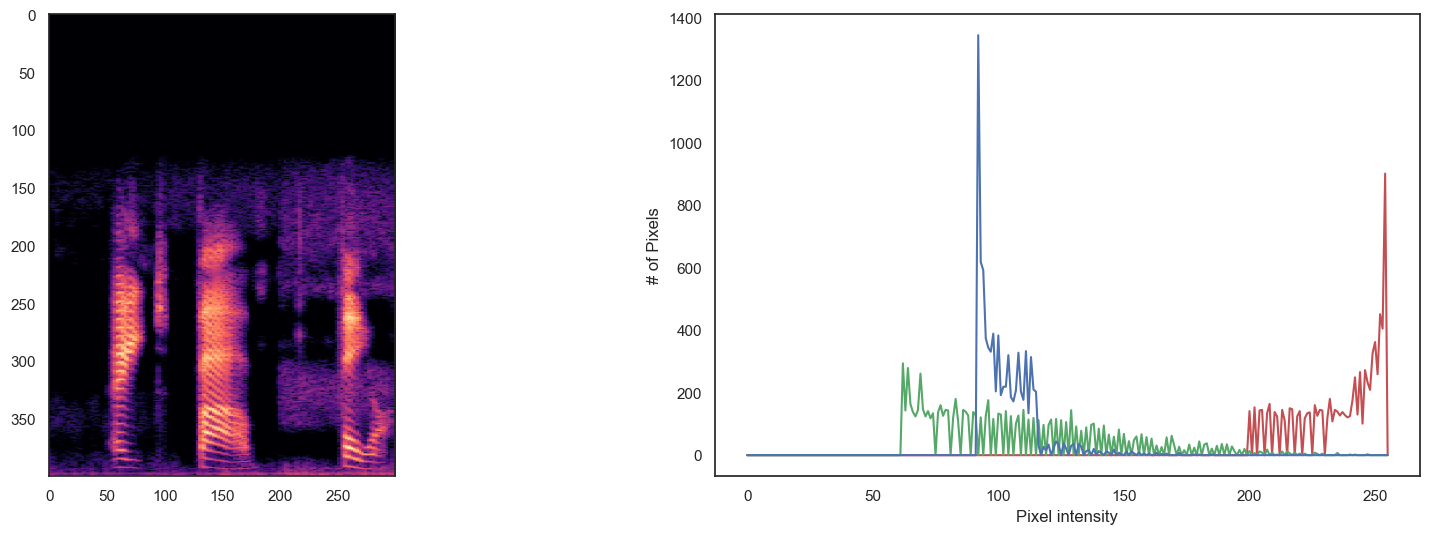

In [252]:
colorHistogram(speaker_1[1].file_path, black_threshold=200)

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Color histograms for different speakers
    </div>

In [293]:
speaker_1 = [spec for spec in spectrogram_data if spec.speaker_id == unique_speakers[0]]
speaker_2 = [spec for spec in spectrogram_data if spec.speaker_id == unique_speakers[1]]

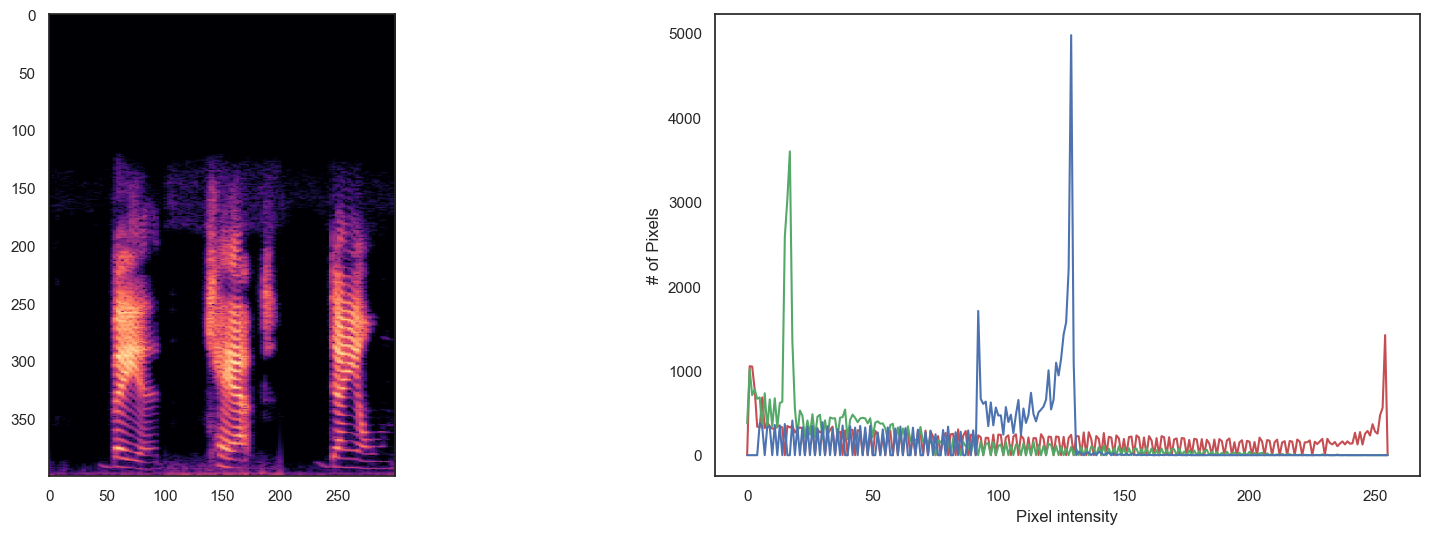

In [294]:
colorHistogram(speaker_1[0].file_path, black_threshold=5)

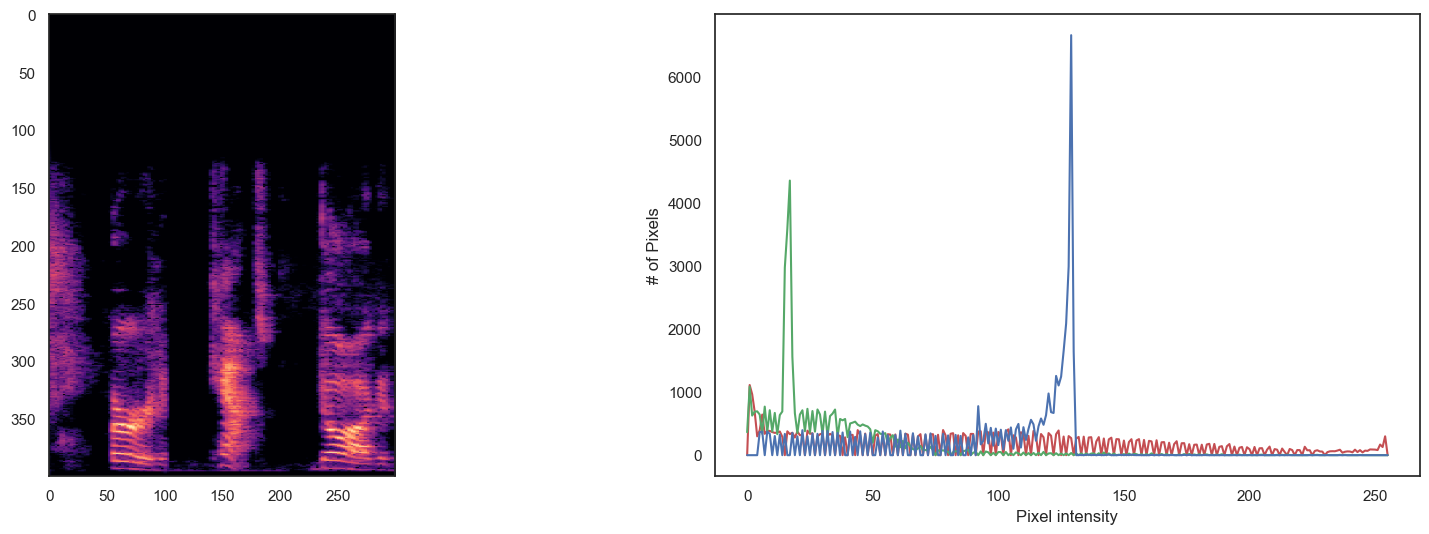

In [295]:
colorHistogram(speaker_2[0].file_path, black_threshold=5)